In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import scipy
import pickle
from scipy.stats import poisson
from scipy.misc import factorial
import pymc3 as pm
from theano.compile.ops import as_op
import theano.tensor as T
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.convolution import CustomKernel

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rebin(array,factorx,factory):
    xedge = np.shape(array)[0]%factorx
    yedge = np.shape(array)[1]%factory
    array_binned1 = array[xedge:,yedge:]

    binim = np.reshape(array_binned1,
                       (np.shape(array_binned1)[0]//factorx,factorx,np.shape(array_binned1)[1]//factory,factory))
    binim = np.mean(binim,axis=3)
    binim = np.mean(binim,axis=1)

    return binim

(21, 21)


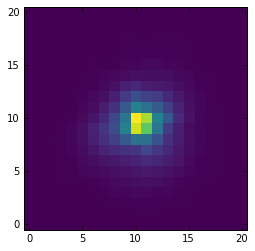

In [3]:
hdul = fits.open('/Users/jmartine/science/chandra/simulated_data/psf_f1_norm_0.25pix.fits')
psf_data = hdul[0].data[118:139,117:138]
plt.imshow(psf_data,origin='lower', cmap='viridis', 
           interpolation='nearest')
print (np.shape(psf_data))

(21, 21)
73.5 84.5


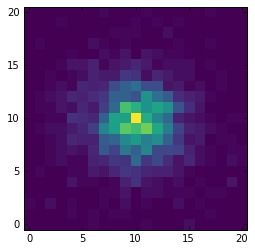

In [4]:
hdul = fits.open('/Users/jmartine/science/chandra/simulated_data/center_box_0.25pix.fits')
img_data = hdul[0].data[66:87,78:99]
plt.imshow(img_data,origin='lower', cmap='viridis', 
           interpolation='nearest')
print (np.shape(img_data))
print(147./2,169./2)

In [5]:
img_binned = rebin(img_data,3,3)

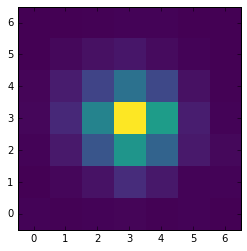

In [6]:
plt.imshow(img_binned,origin='lower', cmap='viridis', 
           interpolation='nearest')

In [7]:
# Simulate the data
np.random.seed(2)
x0low, x0high = 0,21
x1low, x1high = 0,21
dx = 1
x1, x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]

In [8]:
# Convert to 1D arrays
#shape = x0.shape
#x0, x1 = x0.flatten(), x1.flatten()
#shape1 = x0.shape
#print (shape)

# Convert to 1D arrays
shape = x0.shape
x0, x1 = x0.flatten(), x1.flatten()
print (shape)

(21, 21)


In [9]:
from sherpa.astro.models import Beta2D
source_model = pm.Model()

@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dmatrix])
def counts_func(r0, xpos, ypos, ampl, alpha):
    truth = Beta2D()
    truth.xpos, truth.ypos = xpos, ypos
    truth.r0, truth.alpha = r0, alpha
    truth.ampl = ampl
    
    kernel = CustomKernel(psf_data)
    astropy_conv = convolve_fft(truth(x0, x1).reshape(shape), kernel, normalize_kernel=True)
    model_rebin = rebin(astropy_conv,3,3)
    #truth1 = Beta2D()
    #truth1.xpos, truth1.ypos = xpos1, ypos1
    #truth1.r0, truth1.alpha = r01, alpha1
    #truth1.ampl = ampl1
    return model_rebin
    
 
with source_model:
    
    # priors
    #BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=5.0)
    #r0 = BoundedNormal('r0', mu=4.0, sd=2.0)
    r0 = pm.Uniform('r0', lower=0.0, upper=10.0)
    xpos = pm.Normal('xpos', mu=10.0, sd=3.0)
    ypos = pm.Normal('ypos', mu=10.0, sd=3.0)
    ampl = pm.Normal('ampl', mu=100.0, sd=30.0)
    alpha = pm.Uniform('alpha', lower=0.0, upper=10.0)
    #r01 = BoundedNormal('r01', mu=2.0, sd=5.0)
    #xpos1 = pm.Normal('xpos1', mu=3550.0, sd=100.0)
    #ypos1 = pm.Normal('ypos1', mu=4550.0, sd=100.0)
    #ampl1 = pm.Uniform('ampl1', lower=0.0, upper=5000.0)
    #alpha1 = BoundedNormal('alpha1', mu=2.0, sd=5.0)
                       
    counts = counts_func(r0, xpos, ypos, ampl, alpha)
    #counts = np.empty_like(msim)
    
    def log_like(img):
        logpm = np.array(counts - img*np.log(counts))
        return -2.0*np.sum(logpm)
    
    likelihood = pm.DensityDist("likelihood", log_like, observed=img_binned)  
    
    #likelihood = pm.DensityDist("likelihood", log_like, observed=msim)                   
    #likelihood = pm.Poisson('likelihood', mu=counts, observed=msim)

In [10]:
from scipy import optimize

with source_model:
    map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)
    step = pm.Slice()
    trace = pm.sample(10000,step,map_estimate)

  0%|          | 1/10000 [00:00<30:17,  5.50it/s]

Optimization terminated successfully.
         Current function value: -527.382474
         Iterations: 4
         Function evaluations: 221


100%|██████████| 10000/10000 [08:46<00:00, 18.98it/s]


In [11]:
map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)

Optimization terminated successfully.
         Current function value: -527.382474
         Iterations: 4
         Function evaluations: 221


In [12]:
map_estimate

{'alpha_interval_': array(0.2736038149051394),
 'ampl': array(117.60820151312235),
 'r0_interval_': array(-0.1393347617114036),
 'xpos': array(9.615418099313748),
 'ypos': array(10.254365088184345)}

In [46]:
print ((10 - 0) * exp(0.2736038149051394) / (1 + exp(0.2736038149051394)) + 0 )

5.67977421446


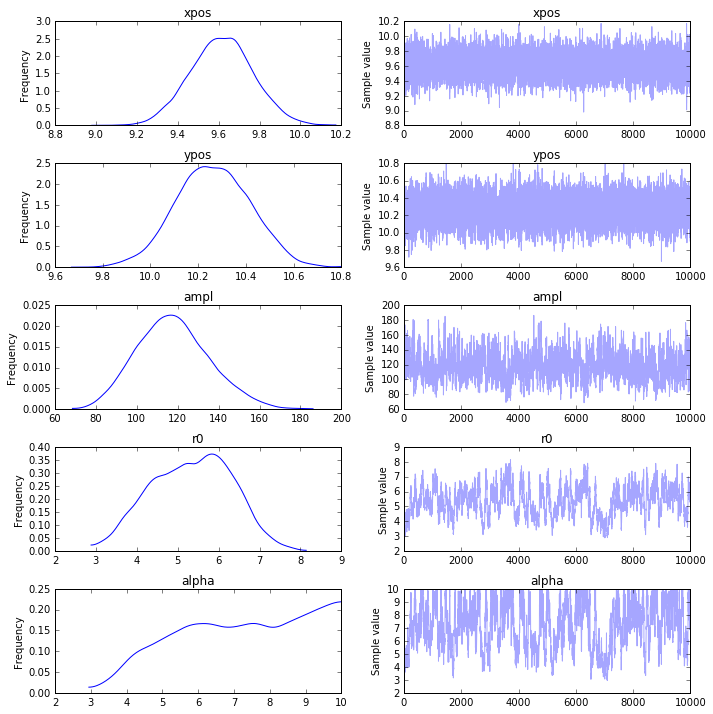

In [13]:
fig, axs = plt.subplots(5, 2,figsize=(10,10)) # 3 RVs
_ = pm.traceplot(trace, ax=axs)
fig.savefig('traces4.pdf')

In [47]:
truth = Beta2D()
#truth.xpos, truth.ypos = 9.61,10.23
#truth.r0, truth.alpha = 4.4, 5.2
#truth.ampl = 130
truth.xpos, truth.ypos = 9.61541,10.254365
truth.r0, truth.alpha = 4.65222, 5.67977
truth.ampl = 117.6082
mexp = truth(x0, x1).reshape(shape)

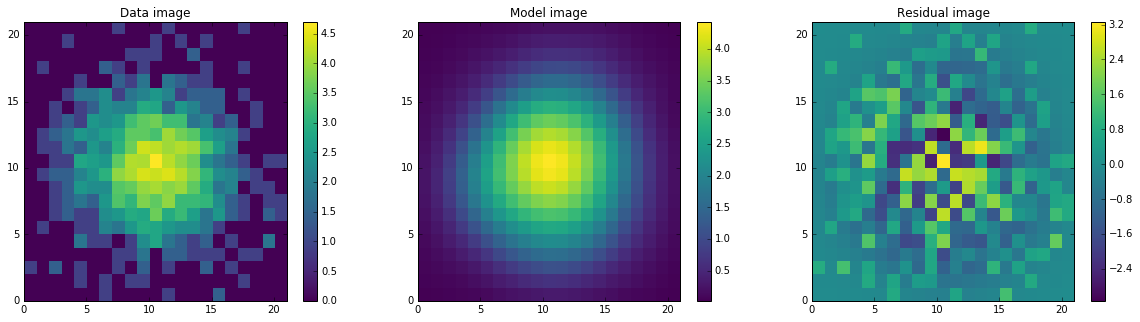

In [48]:
kernel = CustomKernel(psf_data)
conv_model = convolve_fft(mexp, kernel, normalize_kernel=True)

# Plot
plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1)
im = plt.imshow(np.arcsinh(img_data.reshape(shape)), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
cb = plt.colorbar(im)
plt.title('Data image')
plt.subplot(1,3,2)
im = plt.imshow(np.arcsinh(conv_model), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
cb = plt.colorbar(im)
plt.title('Model image')
plt.subplot(1,3,3)
im = plt.imshow(np.arcsinh(img_data.reshape(shape)-conv_model), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
cb = plt.colorbar(im)
plt.title('Residual image')
plt.savefig('PG1634_m6.png')